In [1]:
import sys; sys.path.append('../')
import warnings
warnings.filterwarnings('ignore')
import pickle

from glob import glob
import pandas as pd
import numpy as np
from pathlib import Path

from src.evaluation import nemenyi_critical_values

import matplotlib.pyplot as plt

In [2]:
plt.rcParams["figure.figsize"] = (20,10)
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'font.size': 22})

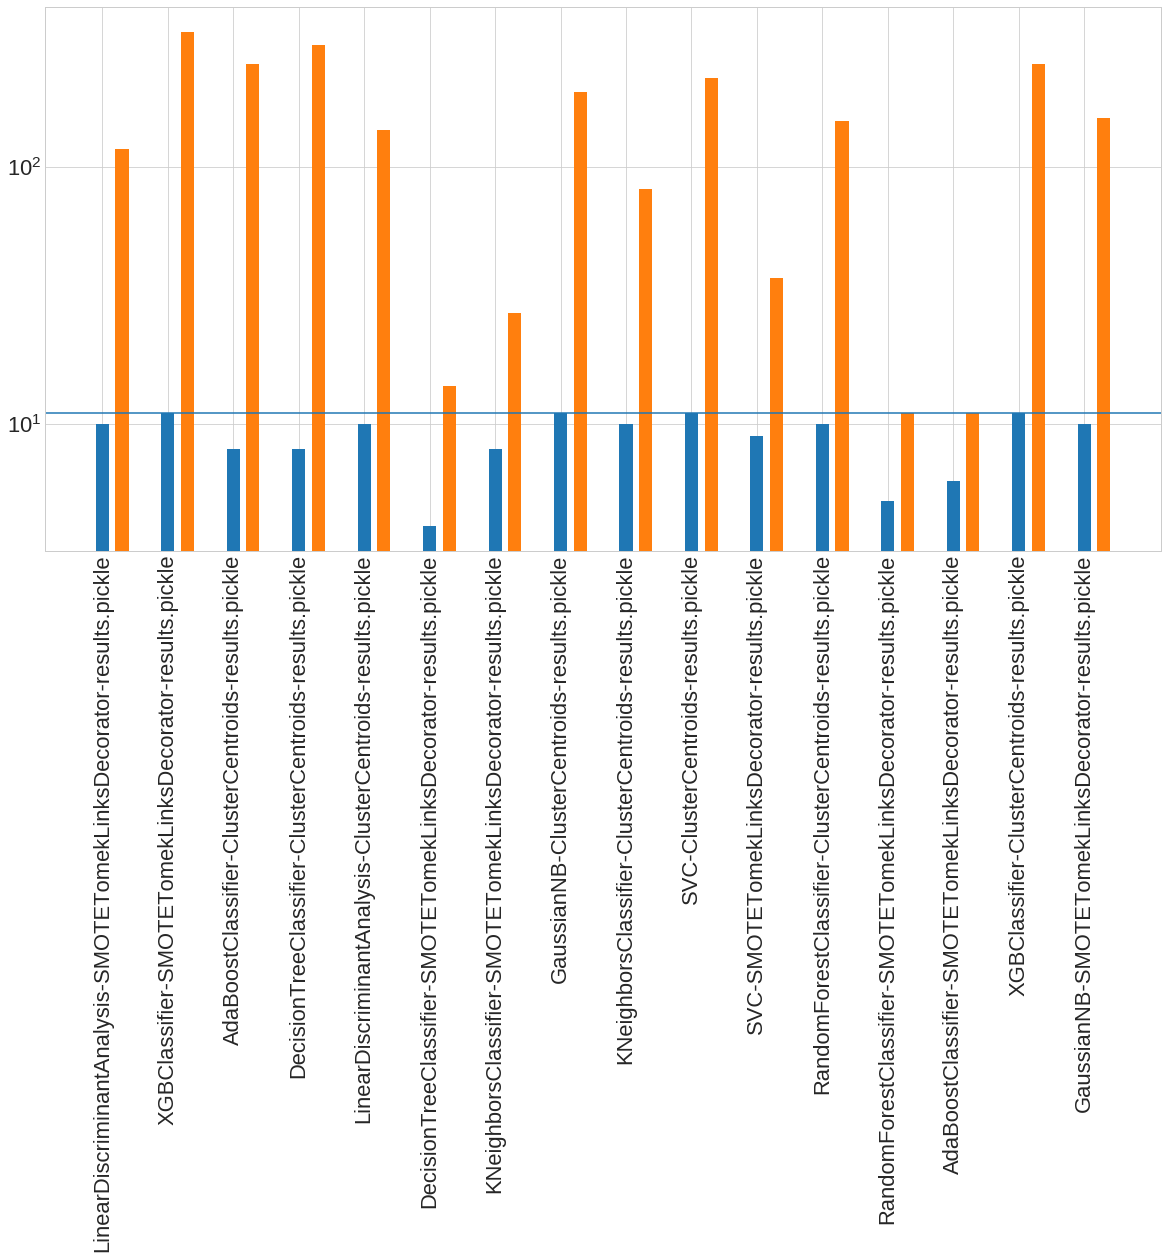

In [3]:
res_paths = glob('../experiments/feature_selection/results/*-results.pickle')

n_cols_plots = 3
n_rows_plots = (len(res_paths) // n_cols_plots) + 1

tps, ts, gts, labels = [], [], [], []
for i, path in enumerate(res_paths):
    path = Path(path)
    with open(path, 'rb') as fh:
        _, y_true, y_pred = pickle.load(fh)
    tps.append(sum(y_true & y_pred))
    ts.append(sum(y_pred))
    gts.append(sum(y_true))
    labels.append(path.name)

plt.figure(figsize=(20,10))
x = np.arange(len(tps))

plt.bar(x, tps, width=0.2)
plt.bar(x + 0.3, ts, width=0.2)

plt.xticks(x, labels, rotation=90)
plt.yscale('log')
plt.axhline(gts[0])

Text(0.5, 1.0, 'Number of features used')

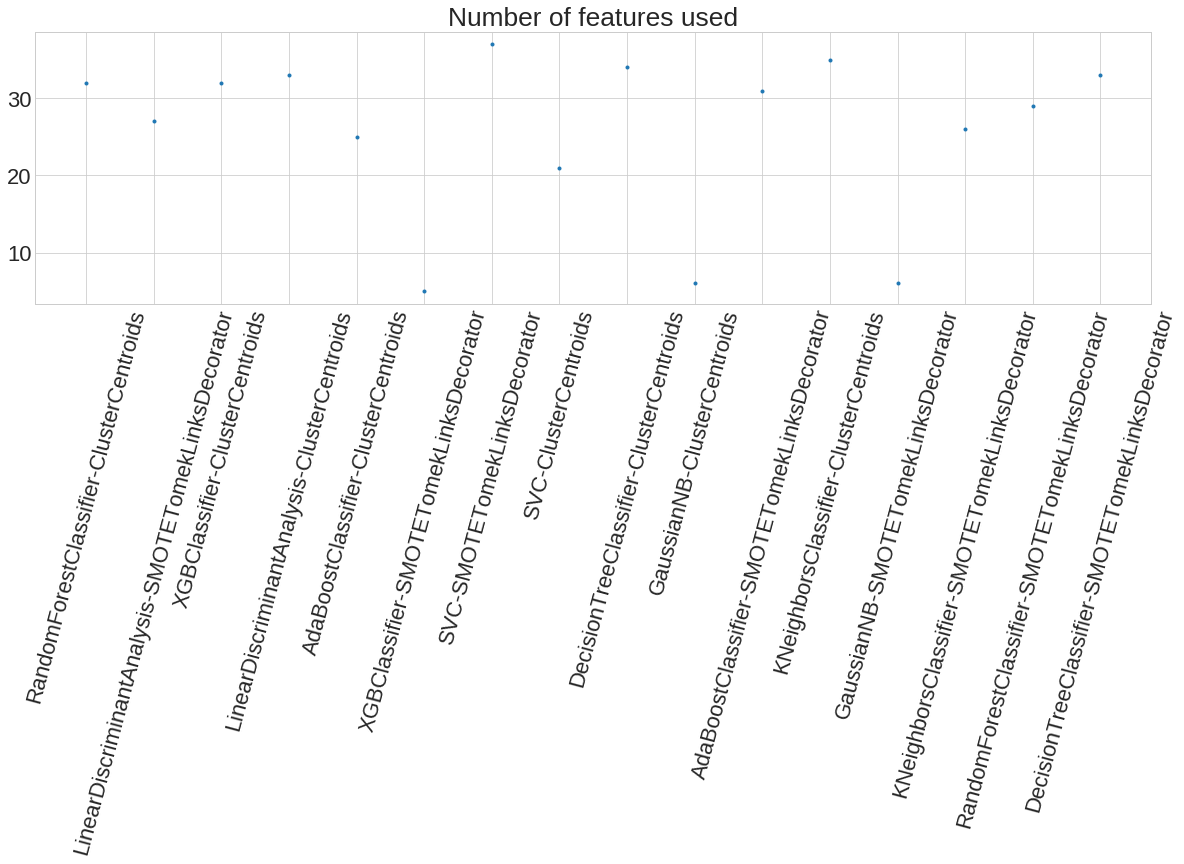

In [4]:
res_paths = glob('../experiments/feature_selection/results/*.pickle')
ns = []
labels = []

for i, path in enumerate(res_paths):
    path = Path(path)
    if 'results' in path.name: continue
    with open(path, 'rb') as fh:
        ns.append(pickle.load(fh)['FEATURE_SELECTION__k'])
        labels.append(path.name.rsplit('.', 1)[0])
plt.figure(figsize=(20, 5))
x = range(len(ns))
plt.scatter(x, ns, marker='.')
plt.xticks(x, labels, rotation=75)
plt.title('Number of features used')

In [5]:
res_paths = glob('../experiments/feature_selection/results/*.pickle')
test_scores = {}

for i, path in enumerate(res_paths):
    path = Path(path)
    if 'results' in path.name: continue
    with open(path, 'rb') as fh:
        conf = pickle.load(fh)
    with open(str(path).rsplit('.', 1)[0] + '-results.pickle', 'rb') as fh:
        results, *_ = pickle.load(fh)
    
    results = pd.DataFrame(results)
    scores = results[results.params == conf].filter(regex='split\d_test*').values
    if len(scores) != 0:
        test_scores[path.name.rsplit('.', 1)[0]] = scores[0]
    else:
        test_scores[path.name.rsplit('.', 1)[0]] =\
            results[results.params.apply(lambda d: d.get('AdaBoostClassifier__n_estimators', None)) == conf['AdaBoostClassifier__n_estimators']]\
                .filter(regex='split\d_test*').values[0]

In [6]:
test_scores.keys()

dict_keys(['RandomForestClassifier-ClusterCentroids', 'LinearDiscriminantAnalysis-SMOTETomekLinksDecorator', 'XGBClassifier-ClusterCentroids', 'LinearDiscriminantAnalysis-ClusterCentroids', 'AdaBoostClassifier-ClusterCentroids', 'XGBClassifier-SMOTETomekLinksDecorator', 'SVC-SMOTETomekLinksDecorator', 'SVC-ClusterCentroids', 'DecisionTreeClassifier-ClusterCentroids', 'GaussianNB-ClusterCentroids', 'AdaBoostClassifier-SMOTETomekLinksDecorator', 'KNeighborsClassifier-ClusterCentroids', 'GaussianNB-SMOTETomekLinksDecorator', 'KNeighborsClassifier-SMOTETomekLinksDecorator', 'RandomForestClassifier-SMOTETomekLinksDecorator', 'DecisionTreeClassifier-SMOTETomekLinksDecorator'])

In [7]:
keys = [
    'AdaBoostClassifier-G_SMOTEDecorator',
    'LinearDiscriminantAnalysis-G_SMOTEDecorator',
    'SVC-ADASYN',
    'KNeighborsClassifier-ADASYN',
    'XGBClassifier-ADASYN',
    'GaussianNB-ADASYN',
    'RandomForestClassifier-ADASYN',
    'DecisionTreeClassifier-G_SMOTEDecorator'
]

In [8]:
new_test_scores = {}
for key in test_scores.keys():
    clf = key.split('-')[0]
    new_test_scores[clf] = test_scores[key]

test_scores = new_test_scores
test_scores = list(test_scores.items())
test_scores = sorted(test_scores, key = lambda l: l[1].mean(), reverse=True)
test_scores

[('SVC', array([0.71666667, 0.71491713, 0.71568627, 0.71525424, 0.71459459])),
 ('KNeighborsClassifier',
  array([0.808     , 0.63989899, 0.82      , 0.64944444, 0.63989899])),
 ('XGBClassifier',
  array([0.71058824, 0.70947368, 0.70948617, 0.71067194, 0.70950704])),
 ('LinearDiscriminantAnalysis',
  array([0.72410714, 0.72368421, 0.725     , 0.64722222, 0.72307692])),
 ('AdaBoostClassifier',
  array([0.94545455, 0.38333333, 0.825     , 0.76666667, 0.6031746 ])),
 ('RandomForestClassifier',
  array([0.82222222, 0.32333333, 0.7375    , 0.66666667, 0.73535354])),
 ('GaussianNB',
  array([0.72109375, 0.56254789, 0.62971311, 0.64256121, 0.72109375])),
 ('DecisionTreeClassifier',
  array([0.74853801, 0.48888889, 0.47      , 0.5952381 , 0.51388889]))]

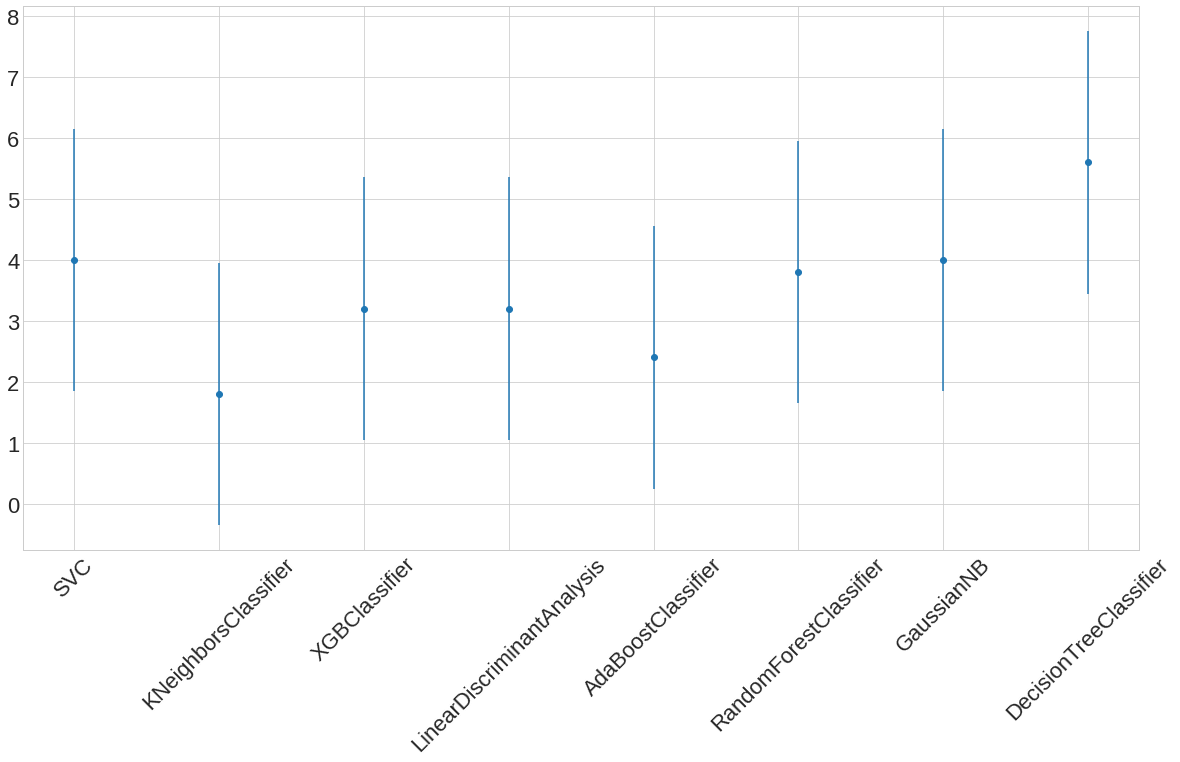

In [9]:
runs = pd.DataFrame(
    [run for _, run in test_scores],
    index=[alg for alg, _ in test_scores]
)

winners = pd.DataFrame(
    [np.argsort(-runs[i]) for i in runs.columns],
    columns=runs.index
).T


n_algs = len(winners)
cv = nemenyi_critical_values[n_algs].loc[0.1]
err = (cv * np.sqrt((n_algs * (n_algs + 1)) / (6 * len(winners.iloc[0])))) / 2
scores = pd.Series(
    [np.mean(e) for _, e in winners.iterrows()],
    index=runs.index
)

plt.figure(figsize=(20,10))
x = range(len(scores))
plt.errorbar(
    x, scores,
    yerr=err, fmt='o'
)
plt.xticks(x, winners.index, rotation=45)
pass

In [10]:
nemenyi_critical_values

,8,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0.01,3.526,3.884,3.914,3.941,3.967,3.992,4.015,4.037,4.057,4.077,4.096,4.114,4.132,4.148,4.164
0.05,3.031,3.426,3.458,3.489,3.517,3.544,3.569,3.593,3.616,3.637,3.658,3.678,3.696,3.714,3.732
0.10,2.780,3.196,3.230,3.261,3.291,3.319,3.346,3.371,3.394,3.417,3.439,3.459,3.479,3.498,3.516
